In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency # chi-sqaure test for independence of variables
from scipy.stats import f_oneway  # One way analysis of variance
import rpy2.robjects.numpy2ri # import package for fisher exact test
from rpy2.robjects.packages import importr

In [2]:
df = pd.read_excel('/content/drive/MyDrive/Q2.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662 entries, 0 to 661
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Created Date      662 non-null    datetime64[ns]
 1   Treatment Rating  662 non-null    object        
 2   Number of Photos  662 non-null    int64         
 3   Number of Words   662 non-null    int64         
 4   Provider Rating   644 non-null    float64       
 5   Physician Type    547 non-null    object        
 6   Treatment Name    662 non-null    object        
 7   Title             662 non-null    object        
 8   Cost              662 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 46.7+ KB


In [7]:
df.head()

,Created Date,Treatment Rating,Number of Photos,Number of Words,Provider Rating,Physician Type,Treatment Name,Title,Cost
0,2019-05-31,Worth it,0,109,5.0,Physician,volbella,From Nervous to Loyal Customer in One Visit!,0.0
1,2019-02-13,Worth it,0,96,5.0,Dermatologic Surgeon,volbella,Dr. Schlessinger did a fantastic job giving me...,0.0
2,2019-01-13,Worth it,2,93,5.0,Plastic Surgeon,volbella,Amazing Artistry!,0.0
3,2019-06-30,Worth it,0,80,5.0,Family Physician,volbella,Expert Injector!,0.0
4,2019-03-21,Not worth it,3,172,NaN,NaN,volbella,Late Reaction to Volbella,750.0


## What does each treatment typically cost? 

In [17]:
cost_table = df[df['Cost']!=0][['Treatment Name','Cost']].groupby(['Treatment Name']).agg('describe')
cost_table

Cost                            ...                            
                count         mean          std  ...      50%        75%     max
Treatment Name                                   ...                            
botox           240.0   464.016292   342.334018  ...   383.50   577.7175  3000.0
chemical peel    10.0   879.013000  1625.890274  ...   142.50   325.0000  5000.0
coolmini          8.0  1193.750000   374.583102  ...  1100.00  1500.0000  1800.0
volbella         10.0   723.512000   545.501897  ...   492.57   737.5000  2200.0

[4 rows x 8 columns]

The cost for 394 (out of 662) consumers is 0, and I assume the reason is that all the fees are covered by consumers’ medical insurance. So the typical cost of each treatment will be calculated without 0. Based on the table above, typical cost of each treatment is in the range between lower quartile and upper quartile).



In [44]:
for i in range(4):
  t = cost_table.index[i]
  l = np.floor(cost_table['Cost']['25%'][t])
  r = np.ceil(cost_table['Cost']['75%'][t])
  print('The cost for %s is about %s to %s dollars'%(t,l,r))

The cost for botox is about 258.0 to 578.0 dollars
The cost for chemical peel is about 108.0 to 325.0 dollars
The cost for coolmini is about 950.0 to 1500.0 dollars
The cost for volbella is about 449.0 to 738.0 dollars


##How to display this data to consumers?

Usually, the lower price makes consumers happier. 

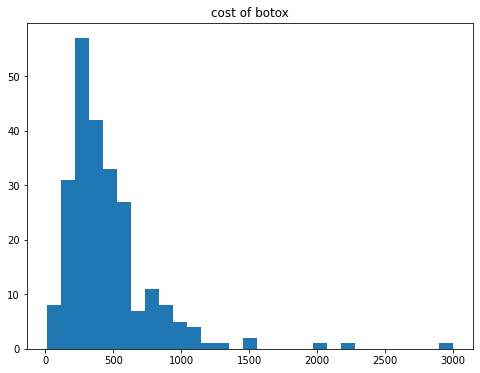

In [47]:
fig, ax = plt.subplots(figsize=(8,6))
data = df[df['Cost']!=0][['Treatment Name','Cost']].groupby(['Treatment Name']).get_group('botox')['Cost']
bins = np.linspace(13, 3000, 30)
plt.hist(data,bins)
plt.title('cost of botox')
plt.show()

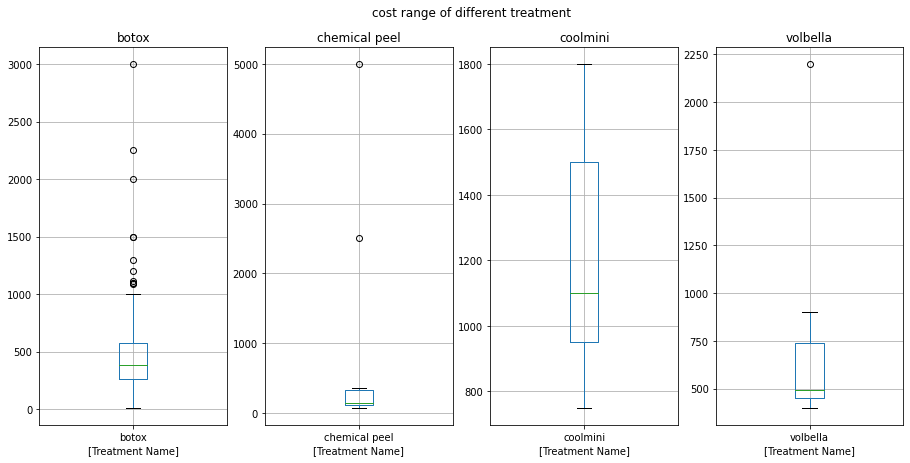

In [49]:
#plt.figure()
fig, ax = plt.subplots(1,4, sharey=False,figsize = (15,7))
p = df[df['Cost']!=0][['Treatment Name','Cost']].groupby(['Treatment Name']).boxplot(column=['Cost'], by=['Treatment Name'],ax= ax,sharey = False)
fig.suptitle('cost range of different treatment')
plt.show()


**In order to overcome consumers’ hesitation caused by cost, I will show the ratio of consumers fully covered by insurance, besides showing the price range of each treatment. Greed bars stand for a ratio of people paying no extra fee.**


In [50]:
# Add a column to track if consumers pay for the treatment

def pay(df):
    if df['Cost'] > 0:
        return 'pay'
    else:
        return "NO cost with insurance"
df.loc[:,"if_pay"] = df.apply(pay,axis=1)   

In [51]:
df.head()

,Created Date,Treatment Rating,Number of Photos,Number of Words,Provider Rating,Physician Type,Treatment Name,Title,Cost,if_pay
0,2019-05-31,Worth it,0,109,5.0,Physician,volbella,From Nervous to Loyal Customer in One Visit!,0.0,NO cost with insurance
1,2019-02-13,Worth it,0,96,5.0,Dermatologic Surgeon,volbella,Dr. Schlessinger did a fantastic job giving me...,0.0,NO cost with insurance
2,2019-01-13,Worth it,2,93,5.0,Plastic Surgeon,volbella,Amazing Artistry!,0.0,NO cost with insurance
3,2019-06-30,Worth it,0,80,5.0,Family Physician,volbella,Expert Injector!,0.0,NO cost with insurance
4,2019-03-21,Not worth it,3,172,NaN,NaN,volbella,Late Reaction to Volbella,750.0,pay


In [52]:
temp = df.groupby(['Treatment Name','if_pay']).size().unstack() 
temp['% pay'] = temp['pay']/(temp['NO cost with insurance']+temp['pay'])
temp['% No cost with insurance'] = temp['NO cost with insurance']/(temp['NO cost with insurance']+temp['pay'])
temp = temp.drop(['NO cost with insurance','pay'],axis= 1)
temp

if_pay,% pay,% No cost with insurance
Treatment Name,,
botox,0.403361,0.596639
chemical peel,0.357143,0.642857
coolmini,0.500000,0.500000
volbella,0.434783,0.565217


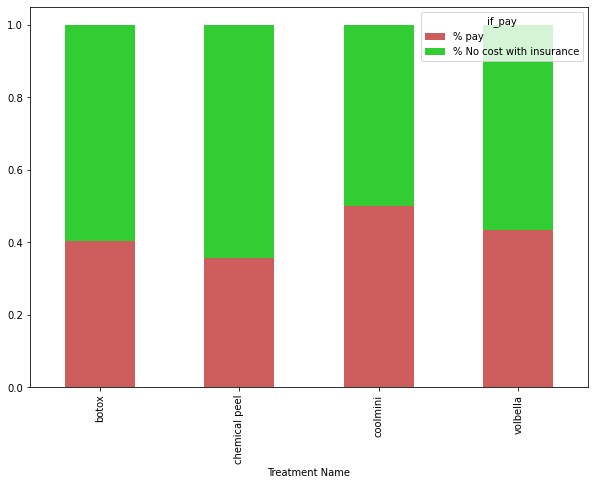

In [53]:
c = ['indianred', 'limegreen']
temp.plot(kind='bar',stacked=True,color=c,figsize=(10,7));

In [54]:
## Categorize the numerical variable, Cost. 
## The range is determined in order to allocating at least 5 samples in each cell in rc contingency table.
def cost_level(dataframe):
  if dataframe['Cost'] == 0:
    return 'no payment'
  elif dataframe['Cost'] <= 400:
    return 'a fair price'
  elif dataframe['Cost'] <= 900:
    return 'acceptable'
  else:
    return 'expensive'
df.loc[:,'cost_level'] = df.apply(cost_level,axis = 1)

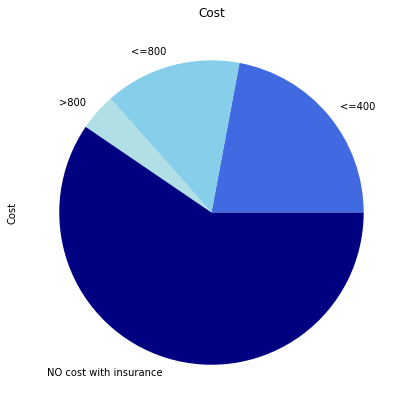

In [56]:
# Another plot showing to consumers
l = ['<=400','<=800','>800','NO cost with insurance']
c = ['royalblue','skyblue','powderblue','navy']
df.groupby(['cost_level'])['Cost'].count().plot(kind = 'pie',figsize = (7,7),labels = l, colors = c)
plt.title('Cost')
plt.show()

## Which treatment is rated the highest by users?

The simplest way to ranking the treatments is based on the treatment rating.

In [57]:
group = df.groupby(["Treatment Name","Treatment Rating"])
rate_table = group.size().unstack()
rate_table

Treatment Rating,Not worth it,Worth it
Treatment Name,,
botox,23,572
chemical peel,3,25
coolmini,2,14
volbella,3,20


In [ ]:
for i in rate_table.index:
    rate = rate_table.loc[i].values[1]/(rate_table.loc[i].values[1]+rate_table.loc[i].values[0])
    print ('Satisfaction rate of %s is %s' %(i,'{:.2f}%'.format(rate*100)))

Satisfaction rate of botox is 96.13%
Satisfaction rate of chemical peel is 89.29%
Satisfaction rate of coolmini is 87.50%
Satisfaction rate of volbella is 86.96%


## How to rank the treatments based on other data?

Since there're only 2 categories in Treatment Rating and most of people rated "worth it", which is not enough to measure consumers' satisfaction. So I'll combine several metrics, including Treatment Rating, Number of photos, Number of words and Provider Rating, to obtain an overall score of satisfaction (out of 10) for each consumer.

#### Treartment Rating

In [58]:
# Based on Treatment Rating, I'll create a column to display cunsumers' sentiment. 1 for positive and -1 for negative.
df.loc[:,"sign"] = df.apply(lambda x: 1 if x['Treatment Rating']=="Worth it" else -1, axis=1)

In [59]:
# Set 5 as basement score, plus 2 for 'Worth it' and 0 for 'Not worth it'.
df.loc[:,"score_tr"] = df.apply(lambda x: 7 if x['sign']== 1 else 5, axis=1)

#### Number of photos

In [ ]:
# Only 54 out of 662 consumers post photo in review, so this is not a powerful metric. Most of these consumers post 1-4 photos.
df[df['Number of Photos'] > 0]['Number of Photos'].describe()

count    54.000000
mean      3.277778
std       3.258757
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max      18.000000
Name: Number of Photos, dtype: float64

In [ ]:
# about 80% consumers who post photo are satisfied with the treatment. And most of these consumers post 1-4 photos as well
df[(df['Number of Photos'] > 0)&(df['Treatment Rating'] == 'Worth it')]['Number of Photos'].describe()

count    41.000000
mean      3.292683
std       3.607242
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max      18.000000
Name: Number of Photos, dtype: float64

In [ ]:
df[(df['Number of Photos'] > 0)&(df['Treatment Rating'] == 'Not worth it')]['Number of Photos'].describe()

count    13.000000
mean      3.230769
std       1.877669
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       8.000000
Name: Number of Photos, dtype: float64

In [ ]:
def score_ph(dataframe):
  if dataframe['Number of Photos'] == 0:
    return 0            # Add 0 point to consumers didn't post photo.
  elif dataframe['Number of Photos'] <=4:
    return 0.2          # Add 0.2 point to consumers posted 1-4 photos
  elif dataframe['Number of Photos'] <= 10:
    return 0.4          # Add 0.4 point to consumers posted 5-10 photos
  else:                 
    return 0.5          # Add 0.5 point to consumers posted 10+ photos.
                        # The points will multiply sign value at last step, so it may decrease the overall score if consumer rated 'Not worth it'.
df.loc[:,'score_ph'] = df.apply(score_ph,axis = 1)  

#### Number of words

In [ ]:
df['Number of Words'].describe() 

count    662.000000
mean      87.483384
std       75.813763
min       28.000000
25%       45.000000
50%       61.000000
75%      101.750000
max      704.000000
Name: Number of Words, dtype: float64

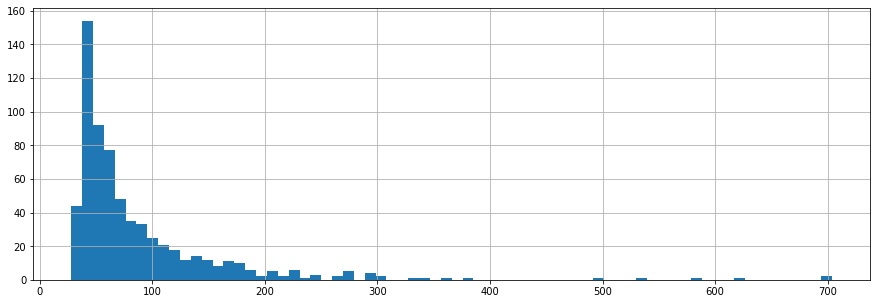

In [ ]:
df['Number of Words'].hist(bins = 70,figsize =(15,5));

In [ ]:
df[df['Treatment Rating'] == 'Worth it']['Number of Words'].describe()

count    631.000000
mean      80.158479
std       56.631672
min       28.000000
25%       44.000000
50%       60.000000
75%       95.500000
max      622.000000
Name: Number of Words, dtype: float64

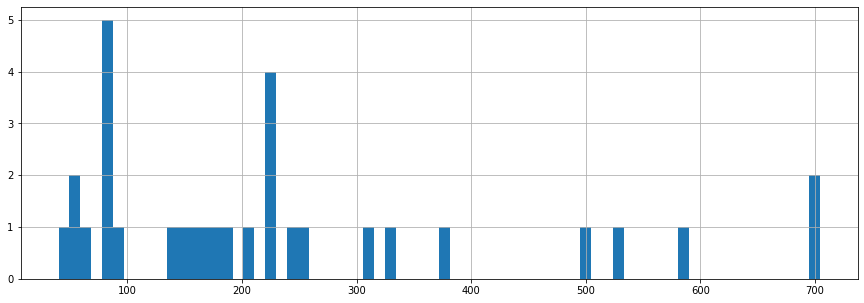

In [ ]:
df[df['Treatment Rating'] == 'Not worth it']['Number of Words'].hist(bins = 70,figsize =(15,5));

In [ ]:
df[df['Treatment Rating'] == 'Not worth it']['Number of Words'].describe()

count     31.000000
mean     236.580645
std      187.595269
min       40.000000
25%       86.000000
50%      187.000000
75%      278.500000
max      704.000000
Name: Number of Words, dtype: float64

In [ ]:
def score_w(dataframe):
  if dataframe['Number of Words'] <= 25:
    return 0.25
  elif dataframe['Number of Words'] <= 50:
    return 0.5
  elif dataframe['Number of Words'] <= 75:
    return 0.75
  elif dataframe['Number of Words'] <= 100:
    return 1
  elif dataframe['Number of Words'] <= 200:
    return 1.25
  elif dataframe['Number of Words'] <= 300:
    return 1.5
  elif dataframe['Number of Words'] <= 400:
    return 1.75
  elif dataframe['Number of Words'] <= 500:
    return 2
  else:
    return 2.25

df.loc[:,'score_w'] = df.apply(score_w,axis = 1)

In [ ]:
df.head()

,Created Date,Treatment Rating,Number of Photos,Number of Words,Provider Rating,Physician Type,Treatment Name,Title,Cost,if_pay,cost_level,sign,score_tr,score_ph,score_w
0,2019-05-31,Worth it,0,109,5.0,Physician,volbella,From Nervous to Loyal Customer in One Visit!,0.0,NO cost with insurance,no payment,1,7,0.0,1.25
1,2019-02-13,Worth it,0,96,5.0,Dermatologic Surgeon,volbella,Dr. Schlessinger did a fantastic job giving me...,0.0,NO cost with insurance,no payment,1,7,0.0,1.00
2,2019-01-13,Worth it,2,93,5.0,Plastic Surgeon,volbella,Amazing Artistry!,0.0,NO cost with insurance,no payment,1,7,0.2,1.00
3,2019-06-30,Worth it,0,80,5.0,Family Physician,volbella,Expert Injector!,0.0,NO cost with insurance,no payment,1,7,0.0,1.00
4,2019-03-21,Not worth it,3,172,NaN,NaN,volbella,Late Reaction to Volbella,750.0,pay,acceptable,-1,5,0.2,1.25


#### Provider Rating

Although it's rating for provider not treatment, consumers' rating for treatment is usually based on overall experience, so this feature is supposed to be considered

In [ ]:
# 18 consumers didn't rate the treatment provider. Satisfication based on Treatment Rating is half and half. 
df[df['Provider Rating'].notna() ==  False].groupby(['Treatment Rating']).size().reset_index(name ='counts')

,Treatment Rating,counts
0,Not worth it,8
1,Worth it,10


In [ ]:
# Most consumers give a high rate(>=4) to the provider.
df[df['Treatment Rating']=="Worth it"].groupby(['Provider Rating']).size().reset_index(name ='counts')

,Provider Rating,counts
0,1.0,1
1,4.0,8
2,5.0,612


In [ ]:
df[df['Treatment Rating']=="Not worth it"].groupby(['Provider Rating']).size().reset_index(name ='counts')

,Provider Rating,counts
0,1.0,18
1,2.0,2
2,3.0,2
3,5.0,1


In [ ]:
def score_pr(dataframe):
  if dataframe['Provider Rating'] == 5:
    return 0.25
  elif dataframe['Provider Rating'] == 4:
    return 0.1
  elif dataframe['Provider Rating'] == 2:
    return -0.3
  elif dataframe['Provider Rating'] == 1:
    return -0.5
  else:
    return 0
df.loc[:,'score_pr'] = df.apply(score_pr,axis = 1)

In [ ]:
df.head(5)

,Created Date,Treatment Rating,Number of Photos,Number of Words,Provider Rating,Physician Type,Treatment Name,Title,Cost,if_pay,cost_level,sign,score_tr,score_ph,score_w,score_pr
0,2019-05-31,Worth it,0,109,5.0,Physician,volbella,From Nervous to Loyal Customer in One Visit!,0.0,NO cost with insurance,no payment,1,7,0.0,1.25,0.25
1,2019-02-13,Worth it,0,96,5.0,Dermatologic Surgeon,volbella,Dr. Schlessinger did a fantastic job giving me...,0.0,NO cost with insurance,no payment,1,7,0.0,1.00,0.25
2,2019-01-13,Worth it,2,93,5.0,Plastic Surgeon,volbella,Amazing Artistry!,0.0,NO cost with insurance,no payment,1,7,0.2,1.00,0.25
3,2019-06-30,Worth it,0,80,5.0,Family Physician,volbella,Expert Injector!,0.0,NO cost with insurance,no payment,1,7,0.0,1.00,0.25
4,2019-03-21,Not worth it,3,172,NaN,NaN,volbella,Late Reaction to Volbella,750.0,pay,acceptable,-1,5,0.2,1.25,0.00


### Overall Rating

In [ ]:
# Calucalte overall score for each consumer
df['score'] = df['score_tr'] + (df['score_ph'] + df['score_w']) * df['sign'] + df['score_pr']

In [ ]:
df['score'].describe()

count    662.000000
mean       7.849849
std        1.087294
min        1.850000
25%        7.750000
50%        8.000000
75%        8.250000
max        9.500000
Name: score, dtype: float64

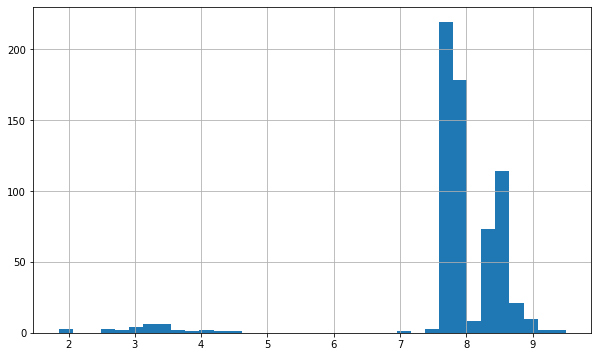

In [ ]:
df['score'].hist(bins = 36,figsize=(10,6));

In [ ]:
rate = df[['Treatment Name','score']].groupby(['Treatment Name'])
rate.agg('describe')

score                                                    
                count      mean       std   min     25%   50%   75%   max
Treatment Name                                                           
botox           595.0  7.869916  1.009318  1.85  7.7500  8.00  8.25  9.50
chemical peel    28.0  7.766071  1.490840  2.55  7.7500  8.00  8.50  9.25
coolmini         16.0  7.606250  1.866447  2.80  7.9375  8.05  8.50  9.15
volbella         23.0  7.602174  1.668660  3.30  7.8750  8.25  8.45  8.90

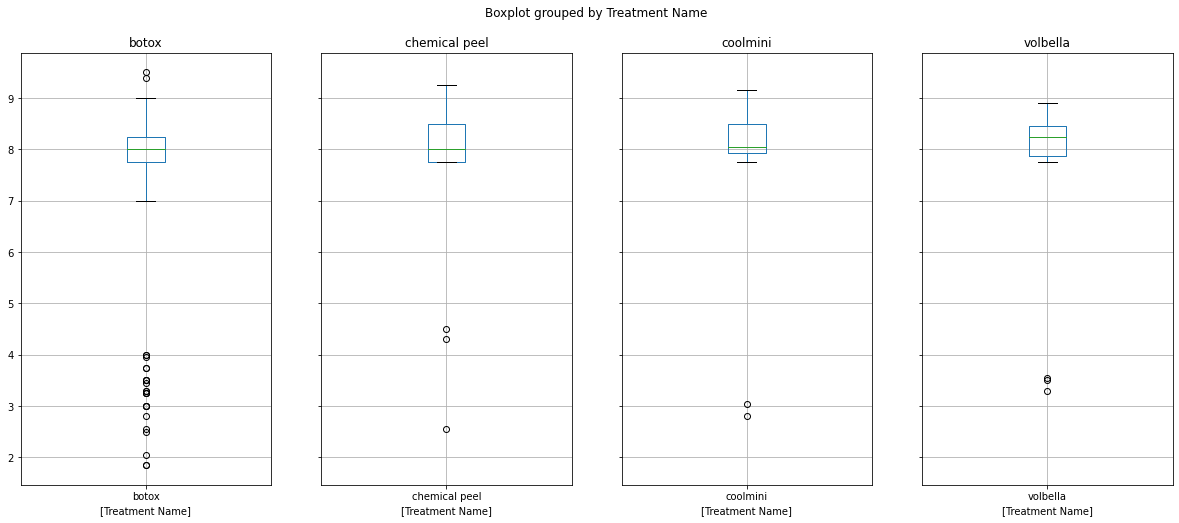

In [ ]:
rate.boxplot(column=['score'], by=['Treatment Name'],layout=(1,4),figsize=(20,8))
plt.show()

In [ ]:
df.to_csv('with_overall_score.csv')

## Are there factors that are correlated with a high rating?

### Indepence between Treatment type and treatment rating

In [ ]:
rate_table

Treatment Rating,Not worth it,Worth it
Treatment Name,,
botox,23,572
chemical peel,3,25
coolmini,2,14
volbella,3,20


In [ ]:
# Apply Chi-square test of independence of variables in a contingency table.
chi2, p, dof, ex = chi2_contingency(rate_table)
chi2,p

(8.964878378919288, 0.029761510613677298)

Assume significance level = 0.05.
P < 0.05, so we reject null hypothesis, then we believe that treatment type is correlated to treatment rating

In [ ]:
# Since 3 cells which sample size is less than 5, Fisher exact test is applied as well for double check

rpy2.robjects.numpy2ri.activate()

In [ ]:
arr = rate_table.to_numpy() # Convert dataframe to array for calculation
stats = importr('stats')
res = stats.fisher_test(arr)
print(res)


	Fisher's Exact Test for Count Data

data:  structure(c(23L, 3L, 2L, 3L, 572L, 25L, 14L, 20L), .Dim = c(4L, 2L))
p-value = 0.01889
alternative hypothesis: two.sided




Fisher exact test result confirm the result.
Treatment type is correlated to rating

In [ ]:
len(df['Physician Type'].unique())


33

In [61]:
df['Physician Type'].isnull().sum()

115

In [ ]:
## There are 115 null values in physician type, and the type name contains too many duplicates so I'll just ignore this feature. 
df.groupby(['Physician Type','Treatment Rating']).size().unstack().head(8)

Treatment Rating,Not worth it,Worth it
Physician Type,,
Anesthesiologist,NaN,1.0
Bariatric Surgeon,NaN,1.0
Board Eligible Plastic Surgeon,NaN,1.0
Dentist,NaN,3.0
Dermatologic Surgeon,1.0,52.0
"Dermatologic Surgeon,Physician,Physician,Pediatrician,Physician,Physician",NaN,1.0
"Dermatologic Surgeon,Plastic Surgeon",NaN,2.0
Dermatologist,NaN,15.0


### Indepence between cost and rating
I guess consumers rating will be affected by cost.
For example, one will be happy for a little change when they pay less, but will be disappointed when change is not that obvious as expected when paying an expensive price.

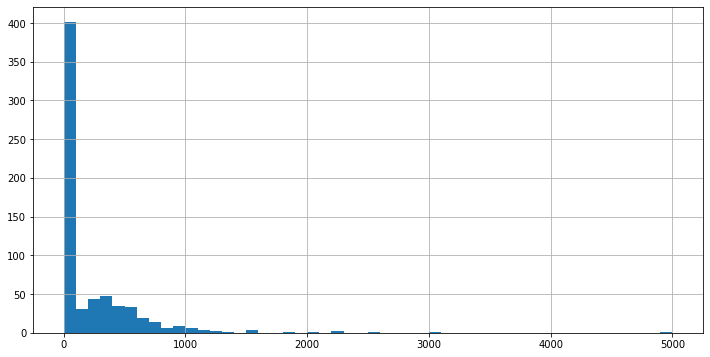

In [ ]:
df['Cost'].hist(bins=50,figsize=(12,6))

In [ ]:
cost = df.groupby(['cost_level','Treatment Rating']).size().unstack()
cost

Treatment Rating,Not worth it,Worth it
cost_level,,
a fair price,10,136
acceptable,5,91
expensive,6,20
no payment,10,384


In [ ]:
chi2_cost, p_cost, dof_cost, ex = chi2_contingency(cost)
chi2_cost, p_cost

(25.36373351025448, 1.2959569200056455e-05)

P << 0.01, so the cost is a main factor correlated to high rating.

### Indepence between provider rating and Treatment rating.

 

In [ ]:
df.groupby(['Provider Rating']).size()

Provider Rating
1.0     19
2.0      2
3.0      2
4.0      8
5.0    613
dtype: int64

In [ ]:
# re-organize data
def provider_satisfy(dataframe):
  if dataframe['Provider Rating'] == 5:
    return 'Satisfied'
  elif dataframe['Provider Rating'] >=3:
    return 'Neutral'
  elif dataframe['Provider Rating'] >= 1:
    return 'Unsatisfied'
  else:
    return 'No rating'
df.loc[:,'provider_satisfy'] = df.apply(provider_satisfy,axis = 1)

In [ ]:
df[df['Provider Rating']!=5].head(5)

,Created Date,Treatment Rating,Number of Photos,Number of Words,Provider Rating,Physician Type,Treatment Name,Title,Cost,if_pay,sign,score_tr,score_ph,score_w,score_pr,score,cost_level,provider_satisfy
4,2019-03-21,Not worth it,3,172,NaN,NaN,volbella,Late Reaction to Volbella,750.0,pay,-1,5,0.2,1.25,0.0,3.55,acceptable,No rating
10,2019-02-05,Not worth it,2,87,1.0,Physician,volbella,DISAPPOINTED,400.0,pay,-1,5,0.2,1.00,-0.5,3.30,a fair price,Unsatisfied
22,2019-06-26,Not worth it,0,79,1.0,Physician,volbella,No way,485.0,pay,-1,5,0.0,1.00,-0.5,3.50,acceptable,Unsatisfied
23,2019-05-10,Worth it,0,229,4.0,NaN,coolmini,CoolMini is definitely worth it,0.0,NO cost with insurance,1,7,0.0,1.50,0.1,8.60,no payment,Neutral
25,2019-03-04,Worth it,5,344,NaN,NaN,coolmini,"22 Years 135 Lbs, Always Had a Double Chin",1500.0,pay,1,7,0.4,1.75,0.0,9.15,expensive,No rating


In [ ]:
satisfy_table = df.groupby(['provider_satisfy','Treatment Rating']).size().unstack()
satisfy_table

Treatment Rating,Not worth it,Worth it
provider_satisfy,,
Neutral,2,8
No rating,8,10
Satisfied,1,612
Unsatisfied,20,1


In [ ]:
arr_1 = satisfy_table.to_numpy() # Convert dataframe to array for calculation
stats = importr('stats')
res_1 = stats.fisher_test(arr_1)
print(res_1)


	Fisher's Exact Test for Count Data

data:  structure(c(2L, 8L, 1L, 20L, 8L, 10L, 612L, 1L), .Dim = c(4L, 2L))
p-value < 2.2e-16
alternative hypothesis: two.sided




P is close to 0, which means provider rating is highly correlated to Treatment rating.
However, this conclusion is somehow meaningless.
Although treatment rating is a measurement of satisfaction for treatment only, we could not exclude the impact from the provider to the consumer. In the other words, consumers rated the treatment based on not only surgery result, but also the experience they have. A patient, responsible and well-communicated physician could give a positive impact on consumers' rating of the treatment with no doubt. So rating for both provider and treatment are almost equivalent.

### ANOVA for testing if making payments affect consumers' rating

In [ ]:
df[['score','if_pay']].groupby('if_pay').describe()

score                                                 
                        count      mean       std   min   25%  50%   75%   max
if_pay                                                                        
NO cost with insurance  394.0  7.942766  0.864499  2.05  7.75  8.0  8.25  9.50
pay                     268.0  7.713246  1.339861  1.85  7.75  8.0  8.25  9.25

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e4a6ccf90>,
      dtype=object)

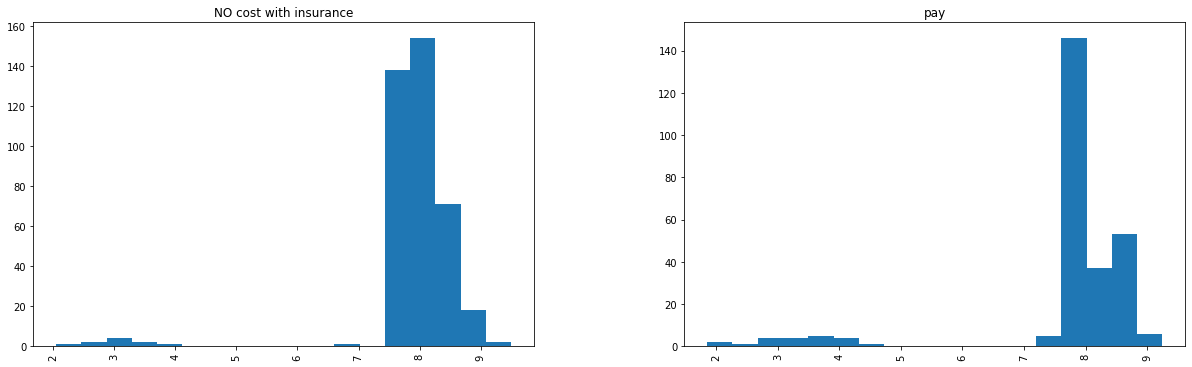

In [ ]:
df[['score','if_pay']].hist(by = 'if_pay',figsize= (20,6),bins =18)

In [ ]:
# group the consumers by paying or not
pay = df[df['if_pay']=='pay']['score']
no_pay = df[df['if_pay']!='pay']['score']

In [ ]:
f_oneway(pay,no_pay)

F_onewayResult(statistic=7.173951145199635, pvalue=0.007581133348999159)

p < 0.01, so the difference between group is statistically significant. Treatment rating is depended on whether consumer paying money  or not.

In [ ]:
# end with code